# Introduction

There is an idea called **Infinite monkey theorem** which states that "a monkey hitting keys at random on a typewriter keyboard for an infinite amount of time will almost surely type any given text, such as the complete works of William Shakespeare". I have heard this idea year ago, and ever since I could not intuitively accept that this is possible. Surely, this sounds like something that could not, under any circumstances, happen? In this notebook, I have come up with a small project to test this assumption on a tiny scale. 

# Import modules

In [31]:
import numpy as np, pandas as pd
import random, time, os
import matplotlib.pyplot as plt, seaborn as sns

# The idea

Let us take the first line of the famous Hamlet's monologue. 

First, we define a set of characters that are comprised of lowercase letters of the English alphabet, comma, and an underscore representing a space. For simplicity, we do not include other characters, such as `'`, `;`, `"`, etc., and the original Hamlet quote will be converted to lowercase and spaces substituted with underscores: 

In [32]:
characters = "abcdefghijklmnopqrstuvwxyz_,"
shakespeare = 'To be, or not to be, that is the question'
shakespeare = shakespeare.replace(' ', '_').lower()
print(shakespeare)

to_be,_or_not_to_be,_that_is_the_question


First, let's see that we can make 5 randomly-selected choices of substring of length k=3:

In [33]:
for i in range(5):
	attempt = random.choices(characters, k=3)
	print(attempt)

['p', 'a', 'w']
['w', 'q', 'l']
['u', 'q', 'x']
['j', 'y', 'y']
['f', 'x', 'g']


We can define a function to call upon with different sizes of substrings, and subsequently call this function on substrings of the original quote. 

For this example, let us do for lengths of 1-3:

In [34]:
def generate_substring(k: int) -> [int, float, str] :
	"""
	Given a string, this function takes a substring such that substring = string[0:k], 
	and then tries to get a substring equal to the chosen one by random selection from the list of characters. 
	"""
	shakespeare_part = shakespeare[0:k]
	counter = 0
	start_time = time.time()
	while True:
		substring = ''.join( random.choices(characters, k=k) )
		if substring == shakespeare_part:
			output_message = f"Found substring '{substring}'!\nAttempts: {counter}\n"
			break
		counter += 1
	end_time = time.time()
	time_elapsed = round(end_time - start_time, 5)
	output_message += f"\nRuntime: {time_elapsed}\n"
	output_message += '-'*30
	return counter, time_elapsed, output_message


for i in range(1, 3+1):
	counter, time_elapsed, output_message = generate_substring(i)
	print(output_message)


Found substring 't'!
Attempts: 48

Runtime: 0.0
------------------------------
Found substring 'to'!
Attempts: 889

Runtime: 0.0
------------------------------
Found substring 'to_'!
Attempts: 846

Runtime: 0.0
------------------------------


# Simulation with 10 replicates

We have devised a formula to run the program for a specified substring of the original quote, starting from the beginning. 

Now let's do the same but more vigorously:
- Do 10 replicates per each substring size; 
- Output the results data (substring length, replicate number, number of attempts, and runtime) to an output text file. 


In [35]:
def process_substring(k: int):
	"""
	Function that randomly constructs a substring of length k from randomly-chosen characters from "characters", 
	until it matches the substring of string of length [0:k]
	"""
	# If the file "output.tsv" doesn't exist, create it and insert a header
	if not os.path.exists('output.tsv'):
		with open('output.tsv', 'w') as output:
			output.write("Substring\tSubstring_length\tReplicate\tAttempts\tRuntime\n")
	# Now that the file definitely exists, let's modify it in the "append" ("a") mode, where whatever you write, appends to the end of the file
	with open('output.tsv', 'a') as output: 
		for j in range(1, 10+1):
			counter, time_elapsed, output_message = generate_substring(k)
			print(f"Replicate {j} processed! Runtime: {time_elapsed:.2f} s")
			output.write(
				f"{shakespeare[0:k].lower()}\t" + 
				f"{k}\t" +
				f"{j}\t" +
				f"{counter}\t" + 
				f"{time_elapsed}\n")

# for i in range(1, 5): # Process substrings of lengths 1 - 4
# 	process_substring(i)
# process_substring(5)
# process_substring(6)
# process_substring(7)

# Data Visualisation

  Substring  Substring_length  Replicate  Attempts  Runtime
0         t                 1          1        21      0.0
1         t                 1          2        31      0.0
2         t                 1          3         8      0.0


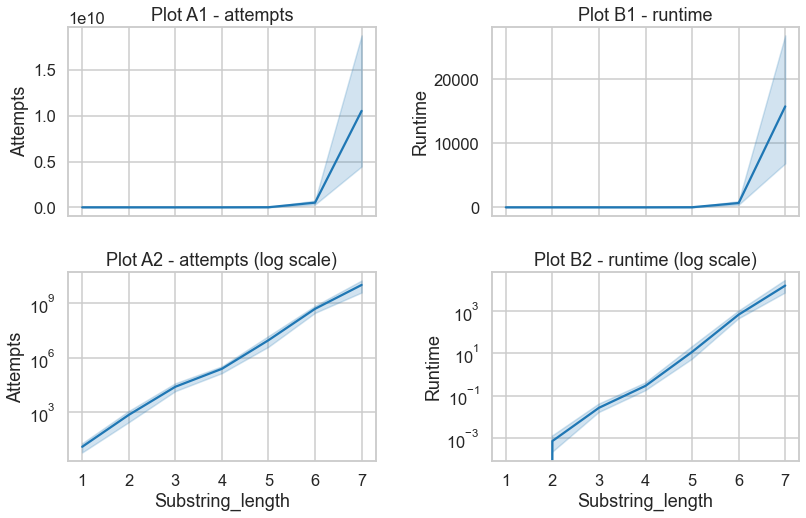

In [36]:
df = pd.read_csv('output.tsv', sep='\t')
print(df.head(3))


fig, axes = plt.subplots(
	2, 2, 
	figsize=(12,8), 
	sharex=True
)

################################################################################

axes[0,0].set_title('Plot A1 - attempts')
sns.lineplot(
	x='Substring_length', y='Attempts', data=df, ax=axes[0,0]
)
# ------------------------------------------------------------------------------
axes[1,0].set_title('Plot A2 - attempts (log scale)')
graph2 = sns.lineplot(
	x='Substring_length', y='Attempts', data=df, ax=axes[1,0]
)
axes[1,0].set_yscale('log')
# ------------------------------------------------------------------------------
axes[0,1].set_title('Plot B1 - runtime')
sns.lineplot(
	x='Substring_length', y='Runtime', data=df, ax=axes[0,1]
)
# ------------------------------------------------------------------------------
axes[1,1].set_title('Plot B2 - runtime (log scale)')
sns.lineplot(
	x='Substring_length', y='Runtime', data=df, ax=axes[1,1]
)
axes[1,1].set_yscale('log')

################################################################################
for i in range(0,2):
	for j in range(0,2):
		axes[i,j].set_xticks([1,2,3,4,5,6,7])

sns.set_context('talk')
sns.set_style('whitegrid')
plt.tight_layout(pad=2)

Now let's **process the data** in the following manner:
1. Perform <u>log transformation of our data (attempts and runtime)</u>, which will enable us to perform linear regression later; 
2. <u>Remove outliers for each group within the variable `Substring_length` </u>. Outliers are defined as values that are lower than $1.5*IQR$ below 25% percentile or higher than $1.5*IQR$ above the 75% percentile; IQR, interquartile range. 
3. Remove log-transformed values that are `-inf`.


  Substring  Substring_length  Replicate  Attempts  Runtime  Attempts_log  \
0         t                 1          1        21      0.0      3.044522   
1         t                 1          2        31      0.0      3.433987   
2         t                 1          3         8      0.0      2.079442   
3         t                 1          4        30      0.0      3.401197   
4         t                 1          5         1      0.0      0.000000   

   Runtime_log  
0         -inf  
1         -inf  
2         -inf  
3         -inf  
4         -inf  


c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_

<AxesSubplot:title={'center':'Runtime no outliers'}, xlabel='Substring_length', ylabel='Runtime_log'>

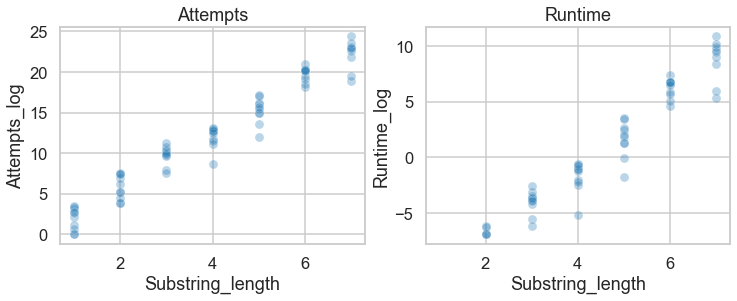

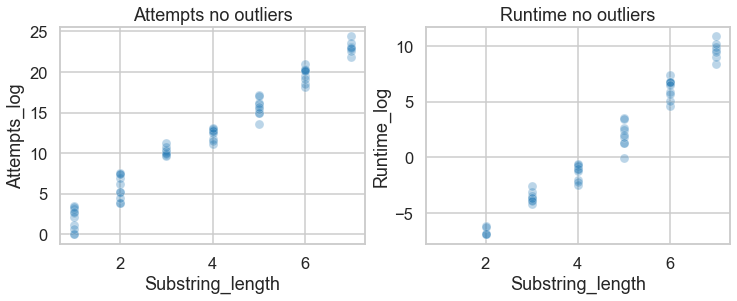

In [37]:
# -------------------------------------------------------------
# ------- Log-transform the data ------------------------------
# -------------------------------------------------------------
df['Attempts_log'] = np.log(df['Attempts'])
df['Runtime_log'] = np.log(df['Runtime'])
print( df.head(5) )

fig, axes = plt.subplots(
	1, 2, 
	figsize=(12,4), 
	sharex=True
)

axes[0].set_title('Attempts')
sns.scatterplot( df['Substring_length'], df['Attempts_log'], alpha=0.3, ax=axes[0] )

axes[1].set_title('Runtime')
sns.scatterplot( df['Substring_length'], df['Runtime_log'], alpha=0.3, ax=axes[1] )


# ------------------------------------------------------------------------------------
# ------- Remove log-transformed values that are '-inf' ------------------------------
# ------------------------------------------------------------------------------------
df_runtime = df[['Substring_length', 'Runtime_log']]
df_runtime = df_runtime[ df_runtime['Runtime_log'] != float('-inf') ]
df_runtime

df_attempts = df[['Substring_length', 'Attempts_log']]
df_attempts


# -------------------------------------------------------------------------------
# ------- Remove outliers in Pandas per each group ------------------------------
# -------------------------------------------------------------------------------
# Ouliers: exceed the boundaries set by top bound (Q3 + 1.5*IQR) 
# and lower bound (Q1 - 1.5*IQR)
def is_outlier(s):
	# lower_limit = s.mean() - (s.std() * 3)
	# upper_limit = s.mean() + (s.std() * 3)
	IQR = s.quantile(0.75) - s.quantile(0.25)
	lower_limit = s.quantile(0.25) - 1.5*IQR
	upper_limit = s.quantile(0.75) + 1.5*IQR
	return s.between(lower_limit, upper_limit)

df_runtime_2 = df_runtime[df_runtime.groupby('Substring_length')['Runtime_log'].apply(is_outlier)]
df_attempts_2 = df_attempts[df_attempts.groupby('Substring_length')['Attempts_log'].apply(is_outlier)]


fig, axes = plt.subplots(
	1, 2, 
	figsize=(12,4), 
	sharex=True
)

axes[0].set_title('Attempts no outliers')
sns.scatterplot( df_attempts_2['Substring_length'], df_attempts_2['Attempts_log'], alpha=0.3, ax=axes[0] )

axes[1].set_title('Runtime no outliers')
sns.scatterplot( df_runtime_2['Substring_length'], df_runtime_2['Runtime_log'], alpha=0.3, ax=axes[1] )


In [38]:
df_runtime_2.head()

,Substring_length,Runtime_log
10,2,-6.907755
11,2,-6.907755
13,2,-6.199719
14,2,-6.907755
15,2,-6.229722


Now we can finally perform Linear Regression on the data, to then try and predict values for much higher length of the string.

c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

Text(1, 23, '$y = -1.2 + 3.5x$')

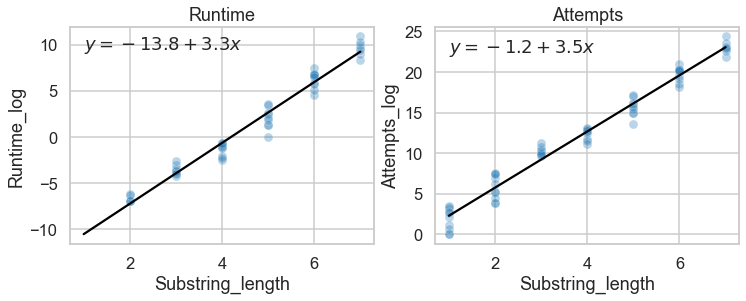

In [39]:
import pandas as pd, matplotlib.pyplot, numpy as np, pandas as pd, seaborn as sns
from scipy.stats import linregress

runtime_slope, runtime_intercept, runtime_r, runtime_p, runtime_se = linregress( df_runtime_2['Substring_length'], df_runtime_2['Runtime_log'] )
attempts_slope, attempts_intercept, attempts_r, attempts_p, attempts_se = linregress( df_attempts_2['Substring_length'], df_attempts_2['Attempts_log'] )

fig, axes = plt.subplots(
	1, 2, 
	figsize=(12,4), 
	sharex=True
)

axes[0].set_title('Runtime')
sns.scatterplot( df_runtime_2['Substring_length'], df_runtime_2['Runtime_log'], alpha=0.3, ax=axes[0] )
x = np.arange(1,8,1)
sns.lineplot( x, runtime_intercept + runtime_slope * x, color='black', ax=axes[0] )
axes[0].text(1, 10, rf'$y = {runtime_intercept:.1f} + {runtime_slope:.1f}x$', horizontalalignment='left', verticalalignment='center')

axes[1].set_title('Attempts')
sns.scatterplot( df_attempts_2['Substring_length'], df_attempts_2['Attempts_log'], alpha=0.3, ax=axes[1] )
x = np.arange(1, 8, 1)
sns.lineplot( x, attempts_intercept + attempts_slope * x, color='black', ax=axes[1] )
axes[1].text(1, 23, rf'$y = {attempts_intercept:.1f} + {attempts_slope:.1f}x$', horizontalalignment='left', verticalalignment='center')


Now, we can predict how long and how many attempts it will take the computer to randomly generate the entire Hamlet. 

- The play Hamlet by Shakespeare has **29,551** words (https://en.wikipedia.org/wiki/Hamlet#:~:text=The%20Tragedy%20of%20Hamlet%2C%20Prince,longest%20play%2C%20with%2029%2C551%20words.); 
- In characters, it is roughly **183,342** characters;
- Therefore, we need to predict how many attempts and runtime it will take to generate the full string of 183,342 characters: 

In [40]:

def predict(intercept, slope, value):
	return intercept + slope*value

# Runtime
print('Runtime')
## first, validate for x = 6
# print(predict(runtime_intercept, runtime_slope, 6))
## now, let's predict for 183,342 characters
characters = 183342
runtime_predicted = predict(runtime_intercept, runtime_slope, characters)
print(f"For {characters} characters, predicted log runtime value is {runtime_predicted:.4f}")
print('-'*60)


# Attempts
print('Attempts')
## first, validate for x = 6
# print(predict(attempts_intercept, attempts_slope, 6))
## now, let's predict for 183,342 characters
attempts_predicted = predict(attempts_intercept, attempts_slope, characters)
print(f"For {characters} characters, predicted log attempts value is {attempts_predicted:.4f}")
print('-'*60)


Runtime
For 183342 characters, predicted log runtime value is 603510.1102
------------------------------------------------------------
Attempts
For 183342 characters, predicted log attempts value is 635053.4580
------------------------------------------------------------


To convert from log to normal (non-log):

$$ log_{e}(runtime) = runtimeLog $$
$$ e^{runtimeLog} = runtime $$

E.g. if we have a log runtime value of $603510$, then $runtime = e^{603510}$. 

Let us make some math transformations, given that $e = 2.718$:

$$ runtime = 2.718^{603510} = (2*1.36)^{603510} = 2^{603510} * 1.36^{603510} $$

For the simplicity of estimation, let's omit $1.36^{603510}$. Please note that the number I have decided to omit is in itself an astonishingly large number, however, for converting the number into recognisable scientific notation we can sacrifice accuracy, bearing in mind that the real number should be much higher than the one obtained by this approximation. 

Then, we can approximate from base 2 to base 10 by multiplying the exponent by 0.3:

$$ 2^{x} \approx 10^{0.3*x}  $$

$$ runtime = 2^{603510} \approx 10^{603510*0.3} = 10^{181053} $$

Now let's perform the same calculation for attempts:

$$ attempts = 2.718^{635053} \approx 2^{635053} \approx 10^{635053*0.3} = 10^{190516} $$



# Results

Therefore, by this prediction, it should take more than $10^{181053}$ seconds and more than $10^{190516}$ attempts for a computer to randomly-generate the entire Hamlet. 

These numbers are astronomically high. For comparison, let us list the other big numbers that can be found in real life:

| Variable | Estimation | Reference |
| --- | --- | --- |
| Age of the universe | $1.4*10^{10}$ years = $4.42*10^{17}$ seconds | https://stardate.org/astro-guide/age-universe-0#:~:text=Most%20astronomers%20agree%20that%20the,methods%20to%20date%20the%20universe. |
| The number of bacteria on Earth | $5*10^{30}$ | https://sciencing.com/how-many-bacteria-live-earth-4674401.html |
| The number of viruses on Earth | $10^{31}$ | https://www.nationalgeographic.com/science/article/factors-allow-viruses-infect-humans-coronavirus |
| Atoms in the observable universe | $10^{78}$ | https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves#:~:text=Remember%20the%20question%20at%20the,hundred%20thousand%20quadrillion%20vigintillion%20atoms |
| The Shannon number - all the possible move variations in chess, including illegal moves | $10^{123}$ | https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves |

*(please note: these numbers are not from the best sources of information (which should be scientific articles), but the purpose here to give a rough ballpark for figures of different biological events, not specific numbers)*



In [41]:
# Finally, let's output our processed data to a file
# df.to_csv('values.tsv', sep='\t', index=False)